# Import libraries

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

# Data overview

In [6]:
from google.colab import files
data =files.upload()
#data = pd.read_csv("fer2013.csv")
#check data shape
#data.shape

Saving fer2013.csv to fer2013.csv


In [9]:
import io
data=pd.read_csv('fer2013.csv')
#data = pd.read_csv(io.StringIO(data['fer2013.csv']),sep=';')
#check data shape
data.shape

(35887, 3)

In [10]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Checking usage values

In [11]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

# Checking target labels

In [12]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


# Visualizing through plot

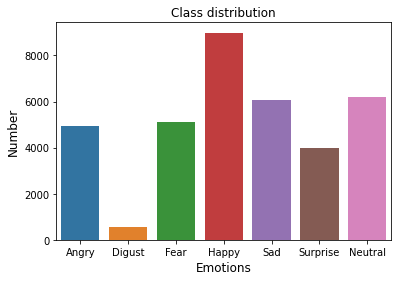

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [14]:
face = data[data['emotion'] == 0].iloc[0]

print(face)

emotion                                                    0
pixels     70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Usage                                               Training
Name: 0, dtype: object


In [15]:
img=np.array(face['pixels'].split())
img

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

In [16]:
img.reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

# Let's make a function to visualize images

In [17]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# Let's visualize images

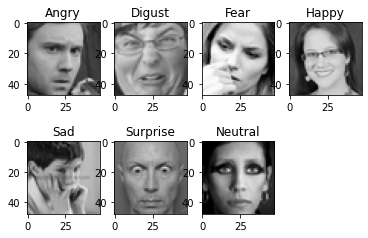

In [18]:
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

# Preprocessing

* Splitting dataset into 3 parts: train, validation, test
* Convert strings to lists of integers
* Reshape to 48x48 and normalise grayscale image with 255.0
* Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [19]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [20]:
data_train_final = pd.concat([data_train, data_val])
data_train_final.shape

(32298, 3)

In [21]:
#df_test_final = pd.concat([data_val, data_test])
#df_test_final.shape

# Train data
## Convert strings to lists of integers

In [22]:
#Train data
data_train_final['pixels'] = data_train_final['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

## Normalizing

In [23]:
width, height = 48, 48
train_X = np.array(data_train_final['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  
train_X.shape

(32298, 48, 48, 1)

## One-hot encoding label

In [24]:
num_classes = 7
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_Y = to_categorical(data_train_final['emotion'], num_classes)  
#train_Y.shape
train_Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

# Test data
## Convert strings to lists of integers

In [25]:
#Validation data
data_test['pixels'] = data_test['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

## Normalizing

In [26]:
width, height = 48, 48
test_X = np.array(data_test['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  
test_X.shape

(3589, 48, 48, 1)

## One-hot encoding label

In [27]:
num_classes = 7 
test_Y = to_categorical(data_test['emotion'], num_classes)  
test_Y.shape

(3589, 7)

# Building CNN Model

## Initializing parameters

In [28]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

## CNN

In [29]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0

# Data Augmentation

In [30]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
trian_aug = data_generator.flow(train_X, train_Y, batch_size)
test_aug =  data_generator.flow(test_X, test_Y,batch_size)                            
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)


history = model.fit(
      trian_aug,
      steps_per_epoch=len(train_X) / batch_size,  # 2000 images = batch_size * steps
      epochs=num_epochs,
      validation_data=test_aug,
      callbacks = [es],
      verbose=2)




#history = model.fit_generator(trian_aug,
                                #steps_per_epoch=len(train_X) / batch_size,
                                #epochs=num_epochs,
                                #verbose=2,
                                #callbacks = [es] 
                                #validation_data = test_aug))


Epoch 1/50
505/504 - 46s - loss: 1.6816 - accuracy: 0.3328 - val_loss: 1.9847 - val_accuracy: 0.2725
Epoch 2/50
505/504 - 47s - loss: 1.3810 - accuracy: 0.4673 - val_loss: 1.4139 - val_accuracy: 0.4553
Epoch 3/50
505/504 - 49s - loss: 1.2367 - accuracy: 0.5247 - val_loss: 1.2616 - val_accuracy: 0.5138
Epoch 4/50
505/504 - 48s - loss: 1.1577 - accuracy: 0.5620 - val_loss: 1.3105 - val_accuracy: 0.5110
Epoch 5/50
505/504 - 49s - loss: 1.1141 - accuracy: 0.5784 - val_loss: 1.1891 - val_accuracy: 0.5294
Epoch 6/50
505/504 - 49s - loss: 1.0784 - accuracy: 0.5906 - val_loss: 1.1365 - val_accuracy: 0.5759
Epoch 7/50
505/504 - 49s - loss: 1.0446 - accuracy: 0.6030 - val_loss: 1.2043 - val_accuracy: 0.5391
Epoch 8/50
505/504 - 49s - loss: 1.0200 - accuracy: 0.6170 - val_loss: 1.2182 - val_accuracy: 0.5623
Epoch 9/50
505/504 - 49s - loss: 0.9947 - accuracy: 0.6219 - val_loss: 1.1239 - val_accuracy: 0.5754
Epoch 10/50
505/504 - 49s - loss: 0.9750 - accuracy: 0.6313 - val_loss: 1.1167 - val_accura

# Visualize Training Performance

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


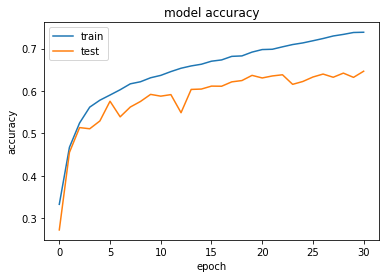

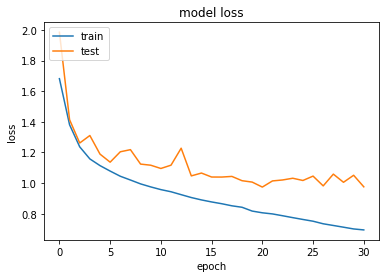

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
ferr_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(ferr_json)
  model.save_weights("model_weights.h5")